# VFI 1.5
## Consumption with income diosyncratic shocks

This notebook is based on [An Stochastic Optimal Gowth Model](https://lectures.quantecon.org/py/optgrowth.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fminbound                       # Minimizer
from scipy import interp                                   # Fast but inaccurate interpolator
from scipy.interpolate import PchipInterpolator, interp1d  # Slow but accurate interpolator

%matplotlib inline
np.random.seed(13)                          # Sets the seed of the random number generator (so we all get the same numbers)
sns.set_style('whitegrid')                  # Makes a nice plot
plt.rc('font', size=16)                     # Increases the fontsize of all plots

## 1. The bellman operator revisited

We are going to repeat the same problem as on Tuesday, but this time with random shocks, so the problem becomes

$$ V(k_t) = \max_{c_t} u(c_t) + \beta  \mathbb{E}_t V(k_{t+1})$$
st
$$ k_{t+1} = f(k_{t} - c_{t} )\xi_{t+1}$$

Where $\xi_{t+1}$ is an idiosincratic shock - meaning it's uncorrelated with $k$ or any other variable, and it is not serially correlated. This is important because it means we don't have information on tomorrow's shock, so when we take expectatios we can just take a mean of expected outcomes. In the next session we will talk on what happens with the shock (for example income) is serially correlated.

The only difference with the previous problem we saw is that now we need to take expectaions of the value function. Which is just a mean in the case of an idiosyncratic, uncorrelated shock. But we solve it the same way: give an initial guess for the function V

From the previous session, you should recognise this function below: it takes in some parameters and gives us one iteration on value functions. The initial guess is ``w``, the capital/asset grid is ``grid``, etc.

> **Task 1:** Read the function, making sure you understand what each line of code does.

> If there is a function you don't remember (like ``ennumerate``) try it out in a cell below.

In [64]:
def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    beta : scalar
        The discount factor
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty(len(w))

    if compute_policy:
        sigma = np.empty(len(w))

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * (shocks)))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [38]:
# cell for trying things

> **Task 2:** Complete the code in the cells below. You need to type in:
> - The utility function, which is going to be log(c) again
> - The production function, which is Cobb-Douglas
> - The grid for k - give it at least 100 values
> - The shocks vector: should be a vector with random values taken from a lognormal distribution with mean 1, std 1.

In [40]:
k_grid = # your code here (you can copy it from the last notebook)
beta = 0.95

SyntaxError: invalid syntax (<ipython-input-40-72c99ddef2a1>, line 1)

In [39]:
def ulog(c):
    return # your code here

def f(k,alpha=0.66): # the alpha=0.66 ensures that alpha is "preset" at 0.66 unless the user changes it
    return # your code here

In [ ]:
shocks = # tip: in a new cell, type in np.random.normal? to read the instructions. You have to set the mean = 1

In [ ]:
w0 = # your code here. Tip: We know the functional form of the answer

In [128]:
def ulog(c):
    return np.log(c)

beta = 0.95
alpha=0.66
mu = 0
sigma = 0.1

def f(k,alpha=alpha): # the alpha=alpha ensures that alpha is "preset" at 0.66 unless the user changes it
    return k**alpha
k_grid = np.linspace(1e-5,5,100)
shocks = np.exp(mu + sigma * np.random.randn(100))

w0 = 2 + 1.5*np.log(k_grid)

Time to try out the function! We now need to write the piece of code that:

- Sets the initial value function to our first guess ``w0``, the tolerance to something small, the distance to 1 and the iteration counter to 0
- While the distance is greater than the tolerance, calls bellam_operator to get a new value function.
- Calculates the distance (the absolute value of the difference of the 2 vectors)
- Resets the current value function ``w`` to be equal to the new value function ``w_next``.
- Adds 1 to the iteration counter and every 50 iterations prints the distance.

Are you up for the challenge?

> **Task 3**: Code the above into the next cell. for this you can either:
> 1. Code it up from scratch (hard mode)
> 2. Copy the code from VFI1 notebook and tweak it a little (easy mode)
> 3. If you are super lost, you can copy it from [here](#sol_2) 


In [88]:
w = w0
tol = 1e-6
distance = 1
iterations = 0
while distance > tol:
    w_next, c_best = bellman_operator(w,k_grid,beta,ulog,f,shocks,compute_policy=True)
    distance = np.abs(np.max(w - w_next))
    w = w_next
    iterations += 1
    if iterations % 50 == 0:
        print ' after {} iterations, distance is {}'.format(iterations, distance)
print 'Done'

 after 50 iterations, distance is 0.712047912546
 after 100 iterations, distance is 0.0420148920115
 after 150 iterations, distance is 0.00254360489177
 after 200 iterations, distance is 0.000158528626429
 after 250 iterations, distance is 1.0191363657e-05
Done


## 2. Plot time

Is this the right answer?

As you may remember from a Macro 2 assignment, there is a pen and pencil solution for this case, which I have coded below for your peace of mind in the ``true_v`` function.

In [131]:
ab = alpha * beta
c1 = np.log(1 - ab) / (1 - beta)
c2 = (mu + alpha * np.log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

def true_v(y):
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

Let's plot the two of them to see if they match

> **Task 4:** Complete the code below. Use the VFI1 as a guide.
>
> Tip: use the option ``label="label name"`` when plotting, so you can see the legend.

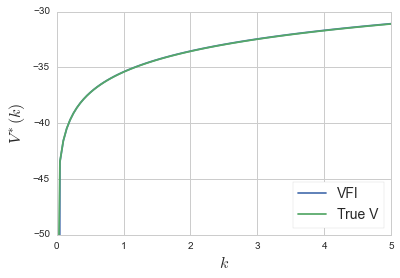

In [141]:
# Code here to obtain the plot of capital versus the value function (from VFI)
# Code here to obtain the plot of capital versus the value function (from algebra)
plt.plot(k_grid,w_next, label="VFI")
plt.plot(k_grid,true_v(k_grid), label="True V")
plt.ylim(-50,-30)
plt.xlabel('$k$', fontsize=16)
plt.ylabel('$V^*(k)$', fontsize=16)
plt.legend(loc='best',frameon=True, fontsize=14)
plt.show()

We can do the same with the policy function. Only that we need a function $c^*(k)$ that returns the optimal consumption policy for any capital, not just the ones in the grid.

> **Task 4**: Create a function called ``policy`` that when given capital $k$ returns the optimal consumption $c^*(k)$.
>
> Use it to plot capital vs optimal consumption, from VFI and from algebra. Do they coincide?
>
> Tip: You may want to look back at ``bellman_operator``

In [142]:
def policy(k):
    return interp(k, k_grid,c_best)

def true_c(k):
    return (1 - alpha * beta) * k  # From algebra

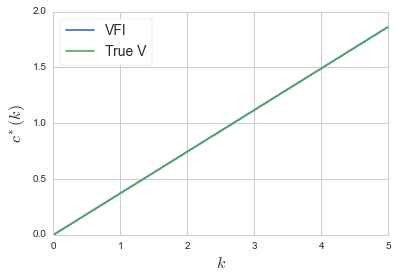

In [143]:
# Code here to obtain the plot of capital versus consumption (from VFI)
# Code here to obtain the plot of capital versus consumption (from algebra)
plt.plot(k_grid,policy(k_grid), label="VFI")
plt.plot(k_grid,true_c(k_grid), label="True V")
plt.xlabel('$k$', fontsize=16)
plt.ylabel('$c^*(k)$', fontsize=16)
plt.legend(loc='best',frameon=True, fontsize=14)
plt.show()

Seems that we are done here!

Feel free to experiment and change the grid for capital, some parameters or even the shocks (within reason). [Here](https://docs.scipy.org/doc/numpy/reference/routines.random.html) is a list of distributions you can use.

## 3. Simulating a consumption path

There is one more fancy plot we can do: a simulation of the path for consumption and capital.

First we need to generate some shocks, then using our policy function we can generate the path for consumption and capital. As this may be the first time you do something like this, I'm going to give you the code almost complete, but it would be great practice for you to code it from scratch.

> **Task 6:** Fill in the blanks to generate the shocks and then the path for capital.

In [126]:
T =100
shock_path=np.exp(0 + 0.1 * np.random.randn(T))

k_path = np.empty(T)
k_path[0] = 0.1

for t in range(T-1):
    k_path[t+1] = (k_path[t] - policy(k_path[t]))**alpha*shock_path[t+1]

Finally, execute the cell below to see all of your good work.

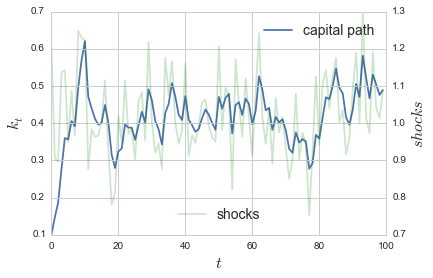

In [159]:
plt.plot(k_path, label='capital path')
plt.ylabel('$k_t$',fontsize=16)
plt.xlabel('$t$',fontsize=16)
plt.legend(loc='best',fontsize=14)
plt.twinx()
plt.plot(shock_path, c='g',alpha=0.2, label='shocks')
plt.legend(loc='best',fontsize=14)
plt.ylabel("$shocks$",fontsize=16)
plt.show()

## Fin

That was all for today. Try this assignment first (better with friends!) and then next Monday we can all meet and go through it together. Don't worry if you get stuck, we'll get through it on Monday.

Next time: markow chains and what to do when the error is correlated.